## Predicting cyclist traffic in Paris

## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

Let's start by a really quick EDA, then we'll think about adding potentially relevent external data points to enrich our analysis.

In [28]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [29]:
import os
os.chdir(r"C:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team")
df = pd.read_parquet(Path("data")/ "train.parquet")
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [30]:
#  Basic Overview
print("=== Basic Information ===")
print(df.info())
print("\n=== First few rows ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             

In [31]:
# Unique Values Analysis
print("\n=== Number of unique values per column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


=== Number of unique values per column ===
counter_id: 56 unique values
counter_name: 56 unique values
site_id: 30 unique values
site_name: 30 unique values
bike_count: 998 unique values
date: 8974 unique values
counter_installation_date: 22 unique values
coordinates: 30 unique values
counter_technical_id: 30 unique values
latitude: 30 unique values
longitude: 30 unique values
log_bike_count: 998 unique values


In [32]:
# Temporal Analysis
# Convert date to datetime if not already
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

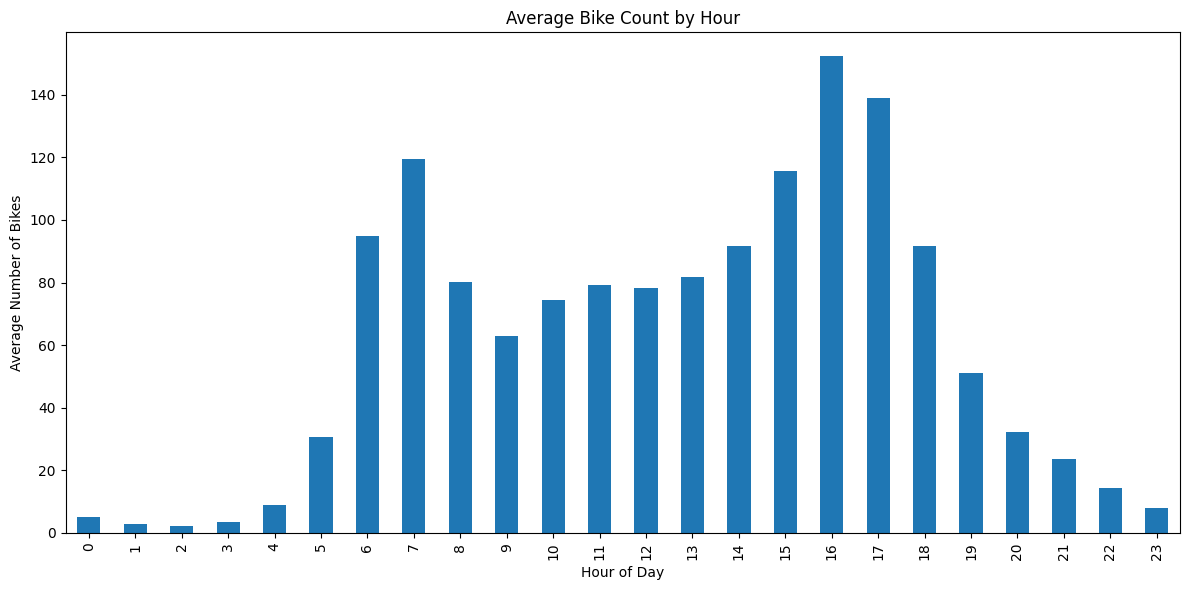

In [33]:

# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['bike_count'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Bike Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.tight_layout()
plt.show()


Kind of as expected people take velibs to go back and from work mostly (so around 7 until 4 or 5). So it would be worthwile to add in holidays in our analysis as external data because I think they can have a huge impact on the ending.

Maybe look up some stats/sondages about velib uses and when/why/who uses velib as part of our EDA.

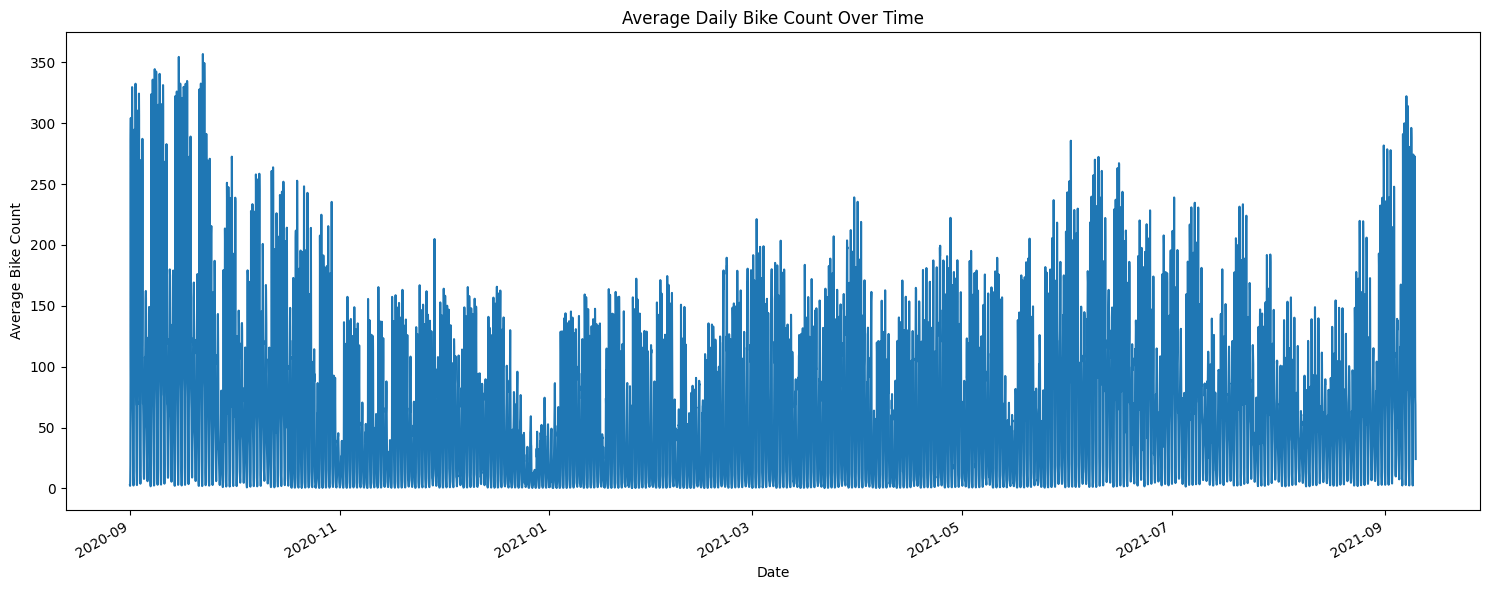

In [34]:

# Time Series View
plt.figure(figsize=(15, 6))
daily_counts = df.groupby('date')['bike_count'].mean()
daily_counts.plot()
plt.title('Average Daily Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.tight_layout()
plt.show()


This seems to confirm my view, for example we can look at around end of decemeber most people are in vacation, it's cold and there is a sharp drop in velib use...

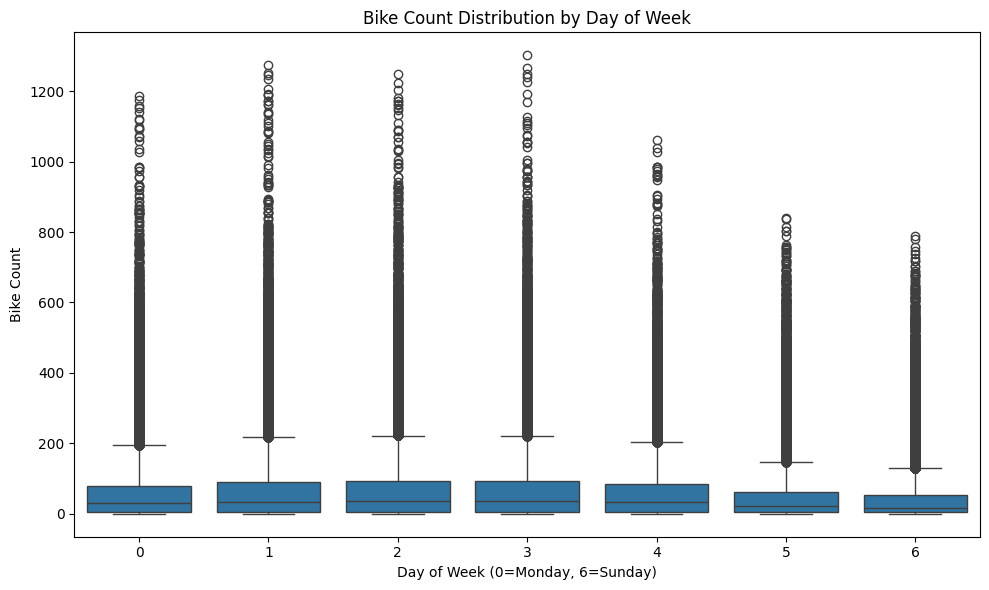

In [35]:

# Day of Week Patterns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='day_of_week', y='bike_count')
plt.title('Bike Count Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Bike Count')
plt.tight_layout()
plt.show()

Kind of uglier than expected

In [36]:
pip install requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Let's work with data.gouv API to have a quick look at my knack about the effect of holidays...

In [37]:
import requests

def get_holidays_from_api(start_year=2020, end_year=2022):
    holidays = []
    for year in range(start_year, end_year):
        url = f"https://calendrier.api.gouv.fr/jours-feries/metropole/{year}.json"
        response = requests.get(url)
        if response.status_code == 200:
            year_holidays = response.json()
            for date, name in year_holidays.items():
                holidays.append({'date': date, 'holiday_name': name})

    return pd.DataFrame(holidays)

In [38]:
holidays = get_holidays_from_api()

In [39]:
holidays

,date,holiday_name
0,2020-01-01,1er janvier
1,2020-04-13,Lundi de Pâques
2,2020-05-01,1er mai
3,2020-05-08,8 mai
4,2020-05-21,Ascension
5,2020-06-01,Lundi de Pentecôte
6,2020-07-14,14 juillet
7,2020-08-15,Assomption
8,2020-11-01,Toussaint
9,2020-11-11,11 novembre


In [41]:
# Create time-based features
df['day'] = df['date'].dt.date
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5
df['hour'] = df['date'].dt.hour

In [40]:
holidays['date'] = pd.to_datetime(holidays['date'])
df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

<Figure size 1500x600 with 0 Axes>

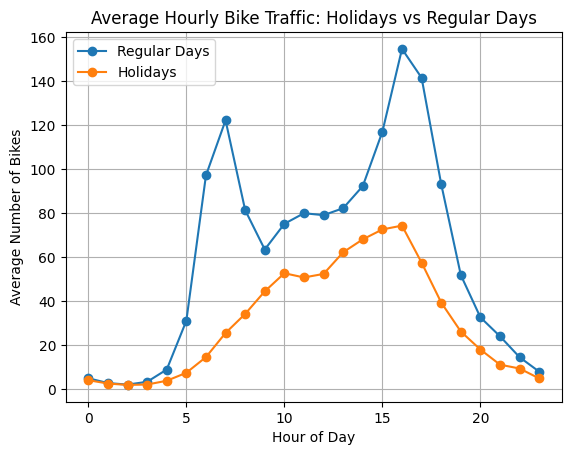

In [25]:
# 2. Compare traffic patterns
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays'])
plt.grid(True)
plt.show()

Nice !! Big impact of holidays ! We will have to add it in our data set in a way (useful external data). Maybe with Zone C vacations also (but do parents use velib ?? we will have to chekc)

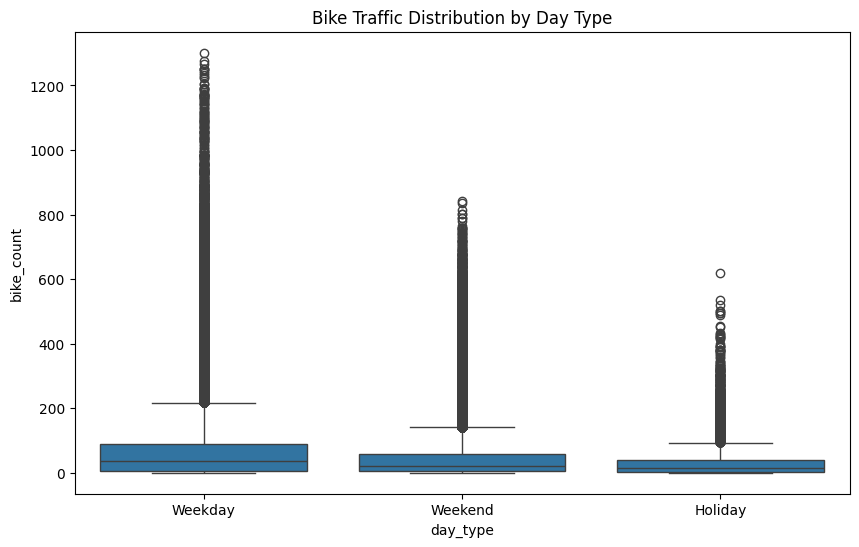

In [42]:

# 4. Box plot comparison including weekends
df['day_type'] = 'Weekday'
df.loc[df['is_weekend'], 'day_type'] = 'Weekend'
df.loc[df['is_holiday'], 'day_type'] = 'Holiday'

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='day_type', y='bike_count')
plt.title('Bike Traffic Distribution by Day Type')
plt.show()
